In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from tqdm import tqdm

from sklearn.metrics import accuracy_score

import sys
sys.path.append('../src')
sys.path.append('../exp')
from Trees import StableTree
from TreeDrawer import Drawer
from TreeEvaluater import dist_tree

### Draw Function

In [2]:
def is_leaf(tree, i):
    return (tree.children_left[i] < 0) and (tree.children_right[i] < 0)

def draw_rectangle(ax, tree, rect, i=-1):
    x1min, x1max, x2min, x2max = rect
    f = tree.feature[i]
    t = tree.threshold[i]
    if not is_leaf(tree, i):
        if f == 0:
            rect_left = [x1min, t, x2min, x2max]
            rect_right = [t, x1max, x2min, x2max]
            ax.plot([t, t], [x2min, x2max], 'k-')
        elif f == 1:
            rect_left = [x1min, x1max, x2min, t]
            rect_right = [x1min, x1max, t, x2max]
            ax.plot([x1min, x1max], [t, t], 'k-')
        draw_rectangle(ax, tree, rect_left, i=tree.children_left[i])
        draw_rectangle(ax, tree, rect_right, i=tree.children_right[i])
    else:
        c = 'b' if np.argmax(tree.value[i]) == 0 else 'r'
        ax.add_patch(
            patches.Rectangle(
                (rect[0], rect[2]),
                rect[1] - rect[0],
                rect[3] - rect[2],
                edgecolor = 'k',
                facecolor = c,
                fill = True,
                alpha = 0.1,
                zorder=100
            ))

### Synthetic Data Example

In [3]:
# seeds
seed_data = 0
seed_tree = 0

# tree parameters
max_depth = 2
eps = 0.3

In [4]:
# synthetic data
np.random.seed(seed_data)
n1, n2, n3 = 10, 20, 10
x = np.concatenate([np.random.randn(n1, 2), np.random.randn(n2, 2) + np.array([[2, 2]]*n2), np.random.randn(n3, 2) + np.array([[4, 4]]*n3)], axis=0)
y = np.concatenate([np.ones(n1), np.zeros(n2), np.ones(n3)])
xte = np.concatenate([np.random.randn(n1, 2), np.random.randn(n2, 2) + np.array([[2, 2]]*n2), np.random.randn(n3, 2) + np.array([[4, 4]]*n3)], axis=0)
yte = np.concatenate([np.ones(n1), np.zeros(n2), np.ones(n3)])

In [5]:
# fit default trees
n_thresholds = 20
stable_tree = StableTree(max_depth=max_depth, seed=seed_tree, eps=eps, n_thresholds=n_thresholds).fit(x, y)
greedy_tree = StableTree(max_depth=max_depth, seed=seed_tree, eps=-1, n_thresholds=n_thresholds).fit(x, y)

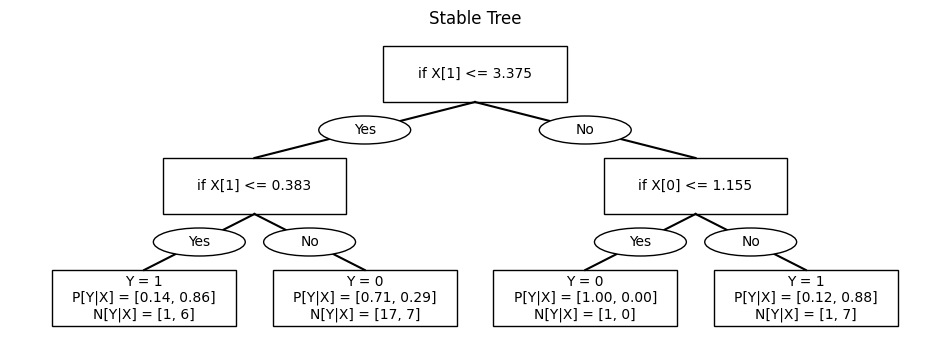

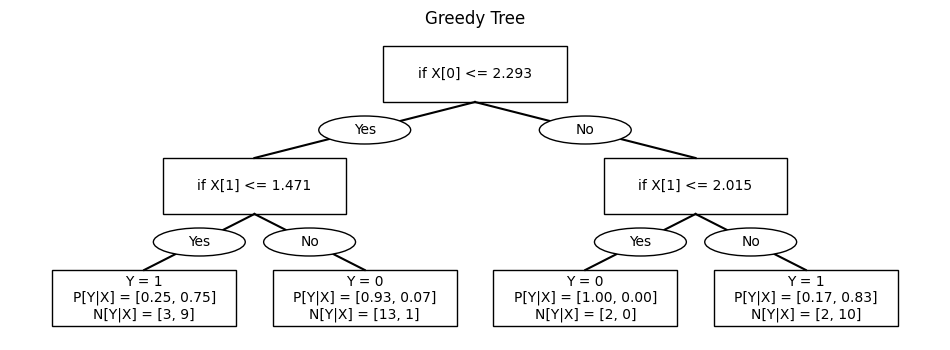

In [6]:
plt.figure(figsize=(12, 4))
drawer = Drawer()
drawer.draw(plt.gca(), stable_tree)
plt.title('Stable Tree')
plt.show()

plt.figure(figsize=(12, 4))
drawer = Drawer()
drawer.draw(plt.gca(), greedy_tree)
plt.title('Greedy Tree')
plt.show()

In [7]:
# evaluation by data removal
data_idx = np.arange(x.shape[0])
dist, acc_tr, acc_te = [], [], []
for n in tqdm(range(x.shape[0])):
    idx_n = np.delete(data_idx, n)

    # fit trees
    stable_tree_n = StableTree(max_depth=max_depth, seed=seed_tree, eps=eps, n_thresholds=n_thresholds).fit(x, y, remove=[n])
    greedy_tree_n = StableTree(max_depth=max_depth, seed=seed_tree, eps=-1, n_thresholds=n_thresholds).fit(x, y, remove=[n])

    # evaluate distance
    d_stable = dist_tree(stable_tree, stable_tree_n)
    d_greedy = dist_tree(greedy_tree, greedy_tree_n)
    dist.append((d_stable, d_greedy))

    # evaluate accuracy - training
    z_stable = stable_tree_n.predict(x[idx_n])
    z_greedy = greedy_tree_n.predict(x[idx_n])
    acc_tr.append((accuracy_score(z_stable, y[idx_n]), accuracy_score(z_greedy, y[idx_n])))

    # evaluate accuracy - test
    z_stable = stable_tree_n.predict(xte)
    z_greedy = greedy_tree_n.predict(xte)
    acc_te.append((accuracy_score(z_stable, yte), accuracy_score(z_greedy, yte)))

dist, acc_tr, acc_te = np.array(dist), np.array(acc_tr), np.array(acc_te)

100%|██████████| 40/40 [00:00<00:00, 124.57it/s]


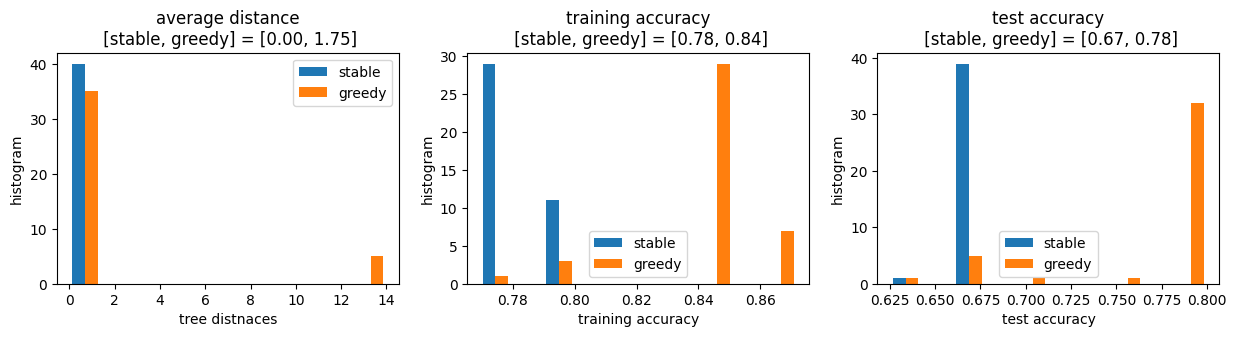

In [8]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.hist(dist)
plt.legend(['stable', 'greedy'])
plt.xlabel('tree distnaces')
plt.ylabel('histogram')
plt.title('average distance\n [stable, greedy] = [%.2f, %.2f]' % (np.mean(dist[:, 0]), np.mean(dist[:, 1])))

plt.subplot(1, 3, 2)
plt.hist(acc_tr)
plt.legend(['stable', 'greedy'])
plt.xlabel('training accuracy')
plt.ylabel('histogram')
plt.title('training accuracy\n [stable, greedy] = [%.2f, %.2f]' % (np.mean(acc_tr[:, 0]), np.mean(acc_tr[:, 1])))

plt.subplot(1, 3, 3)
plt.hist(acc_te)
plt.legend(['stable', 'greedy'])
plt.xlabel('test accuracy')
plt.ylabel('histogram')
plt.title('test accuracy\n [stable, greedy] = [%.2f, %.2f]' % (np.mean(acc_te[:, 0]), np.mean(acc_te[:, 1])))

plt.show()

### Example of Unstable Case

In [9]:
# unstable data
idx_dist = np.where(np.max(dist, axis=1)>0)[0]
for i, d in zip(idx_dist, dist[idx_dist, :]):
    print(i, d)

21 [ 0 14]
31 [ 0 14]
33 [ 0 14]
36 [ 0 14]
37 [ 0 14]


In [10]:
# target data to be removed
n = 31
eps = 0.3

In [11]:
# fit trees
stable_tree = StableTree(max_depth=max_depth, seed=seed_tree, eps=eps, n_thresholds=n_thresholds).fit(x, y)
greedy_tree = StableTree(max_depth=max_depth, seed=seed_tree, eps=-1, n_thresholds=n_thresholds).fit(x, y)
stable_tree_n = StableTree(max_depth=max_depth, seed=seed_tree, eps=eps, n_thresholds=n_thresholds).fit(x, y, remove=[n])
greedy_tree_n = StableTree(max_depth=max_depth, seed=seed_tree, eps=-1, n_thresholds=n_thresholds).fit(x, y, remove=[n])

# evaluate distance
d_stable = dist_tree(stable_tree, stable_tree_n)
d_greedy = dist_tree(greedy_tree, greedy_tree_n)
print(d_stable, d_greedy)

0 14


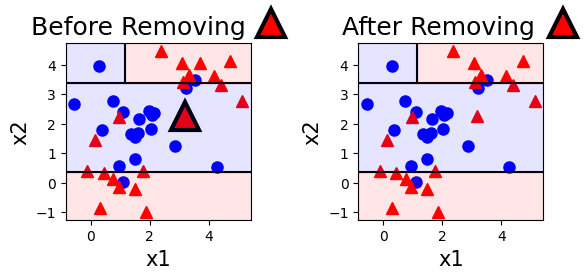

In [12]:
plt.figure(figsize=(6, 3))
c = 'bo' if y[n] == 0 else 'r^'

plt.subplot(1, 2, 1)
plt.plot(x[y==0, 0], x[y==0, 1], 'bo', ms=8)
plt.plot(x[y==1, 0], x[y==1, 1], 'r^', ms=8)
plt.plot(x[n, 0], x[n, 1], c, ms=20, mec='k', mew=3)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
draw_rectangle(plt.gca(), stable_tree, [xlim[0], xlim[1], ylim[0], ylim[1]])
plt.gca().set_aspect('equal')
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.plot(6.1, 5.4, c, ms=20, mec='k', mew=3, clip_on=False)
plt.title('Before Removing     ', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(x[idx_n][y[idx_n]==0, 0], x[idx_n][y[idx_n]==0, 1], 'bo', ms=8)
plt.plot(x[idx_n][y[idx_n]==1, 0], x[idx_n][y[idx_n]==1, 1], 'r^', ms=8)
draw_rectangle(plt.gca(), stable_tree_n, [xlim[0], xlim[1], ylim[0], ylim[1]])
plt.gca().set_aspect('equal')
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.plot(6.1, 5.4, c, ms=20, mec='k', mew=3, clip_on=False)
plt.title('After Removing   ', fontsize=18)

plt.tight_layout()
#plt.show()
plt.savefig('./demo_stable.pdf')

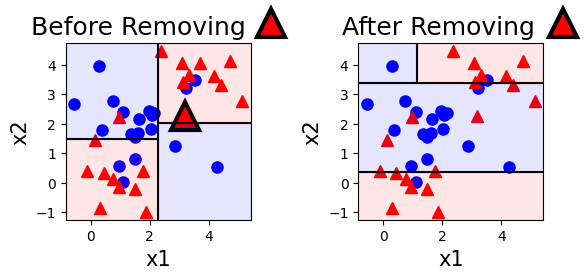

In [13]:
plt.figure(figsize=(6, 3))
c = 'bo' if y[n] == 0 else 'r^'

plt.subplot(1, 2, 1)
plt.plot(x[y==0, 0], x[y==0, 1], 'bo', ms=8)
plt.plot(x[y==1, 0], x[y==1, 1], 'r^', ms=8)
plt.plot(x[n, 0], x[n, 1], c, ms=20, mec='k', mew=3)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
draw_rectangle(plt.gca(), greedy_tree, [xlim[0], xlim[1], ylim[0], ylim[1]])
plt.gca().set_aspect('equal')
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.plot(6.1, 5.4, c, ms=20, mec='k', mew=3, clip_on=False)
plt.title('Before Removing     ', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(x[idx_n][y[idx_n]==0, 0], x[idx_n][y[idx_n]==0, 1], 'bo', ms=8)
plt.plot(x[idx_n][y[idx_n]==1, 0], x[idx_n][y[idx_n]==1, 1], 'r^', ms=8)
draw_rectangle(plt.gca(), greedy_tree_n, [xlim[0], xlim[1], ylim[0], ylim[1]])
plt.gca().set_aspect('equal')
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.plot(6.1, 5.4, c, ms=20, mec='k', mew=3, clip_on=False)
plt.title('After Removing   ', fontsize=18)

plt.tight_layout()
#plt.show()
plt.savefig('./demo_greedy.pdf')